In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

Use Masking Layer to create an ImageNet that only predicts for Stanford Dogs dataset.
Need mapping list of indices between full ImageNet and Stanford Dogs.

Concept:
start with existing Stanford Dogs notebook about transfer learning.
Need mapping list of indices between full ImageNet and Stanford Dogs.

Load ImageNet model.
Download any subset of ImageNet with original indexes, preferably a mix with some dogs.
Predict from subset
Display misclassified image pairs. 


Stanford Dogs section
Create 2-way mapping tables
Predict SD only:
Create Dataset which maps index to ImageNet index
Predict Stanford Dogs from ImageNet with evaluate.
Predict again, pulling logits, counting misclassified outside of SD index list.
Display misclassified outside 

Save weights to file.
Pop final Dense layer.
Get name and config params, verify activation = softmax
Create new Dense layer with same shape and name, no activation.
Create simple Model with just Dense layer
'load weights by name' into new Model
now have Dense with no activation
Add Dense to ImageNet model.
Add Masking to ImageNet model.
Add Softmax layer.



In [ ]:

IMG_SIZE = 224
DENSE_INPUT = 1280
IMAGENET_CLASSES = 1000
STANFORD_DOGS_CLASSES = 120
batch_size = 64



The Stanford Dogs image set is a subset of ImageNet-1000, and occupies a few ranges of indexes in the larger dataset. (Stanford Dogs does not include several wild canid species, sticking entirely to domestic breeds.) The Stanford Dogs label range is different than IN-1k, so we have to map the indexes back to the IN-1k index range. 

In [ ]:
def sd2imagenet(index):
    if index >= 0 and index <= 99:
        return index + 151
    elif index >= 100 and index <= 116:
        return index + 152
    elif index >= 117 and index <= 119:
        return index + 156
    else:
        return -1

def imagenet2sd(index):
    if index >= 151 and index <= 250:
        return index - 151
    elif index >= 252 and index <= 268:
        return index - 152
    elif index >= 273 and index <= 275:
        return index - 156
    else:
        return -1

def get_sd_mask():
    masks = [0.0] * IMAGENET_CLASSES 
    for index in range(STANFORD_DOGS_CLASSES):
        masks[sd2imagenet(index)] = 1.0
    return masks

STANFORD_DOGS_MASK = get_sd_mask()
ANIMALS_MASK = np.zeros((IMAGENET_CLASSES,))
ANIMALS_MASK[:398] = 1.0
ANIMALS_MASK = ANIMALS_MASK.tolist()

Load the Stanford Dogs TF Dataset, prepare iterators, and map the indexes.

In [ ]:
dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
def input_preprocess(image, label):
    mapped = sd2imagenet(int(label))
    onehot = tf.one_hot(mapped, IMAGENET_CLASSES)
    return image, onehot
ds_train = ds_train.map(
    input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)
ds_test = ds_test.map(
    input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))
# forget input augmentation as we are not training
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)


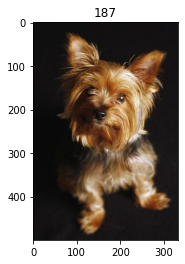

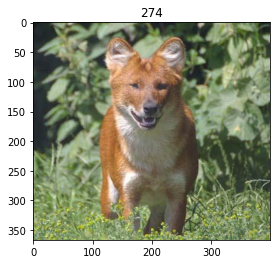

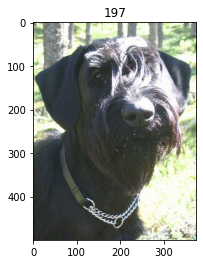

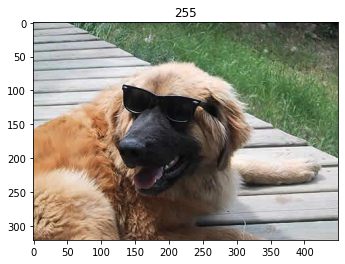

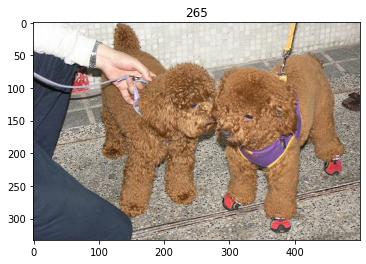

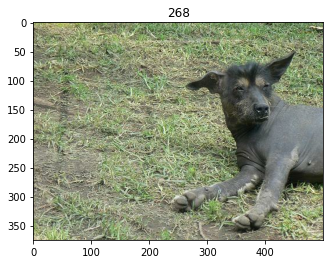

In [ ]:
(ds2_train, ds2_test), ds_info = tfds.load(
    dataset_name, split=["train","test"], with_info=True
)
ds2_mini = ds2_train.take(6)

def gen(ds):
    for dog in ds:
        # print(type(dog))
        # print(len(dog))
        yield dog['image'], dog['label']

get_name = ds_info.features['label'].int2str

for image,label in gen(ds2_mini):
    mapped = sd2imagenet(int(label))
    # print(image.shape)
    # print(label)
    plt.figure()
    plt.imshow(image)
    plt.title(str(mapped))

<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(64, 1000), dtype=float32)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


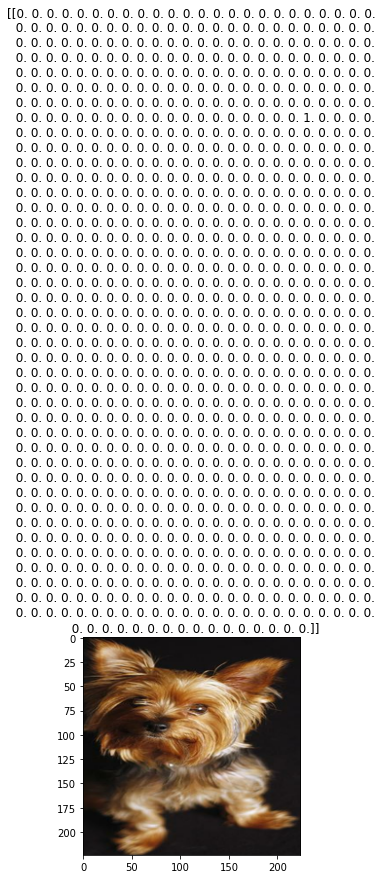

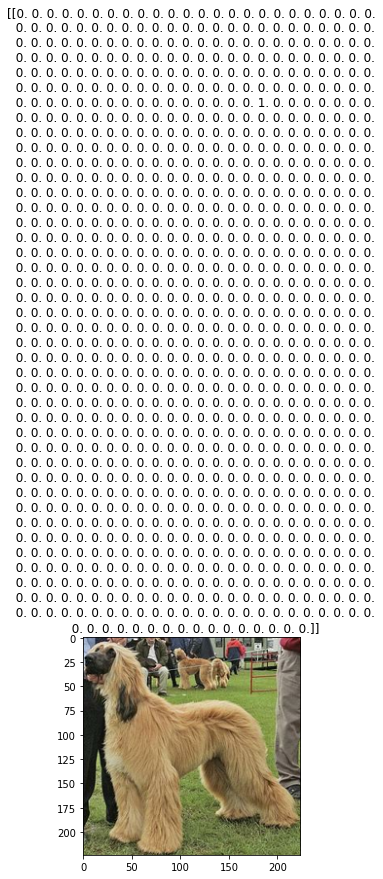

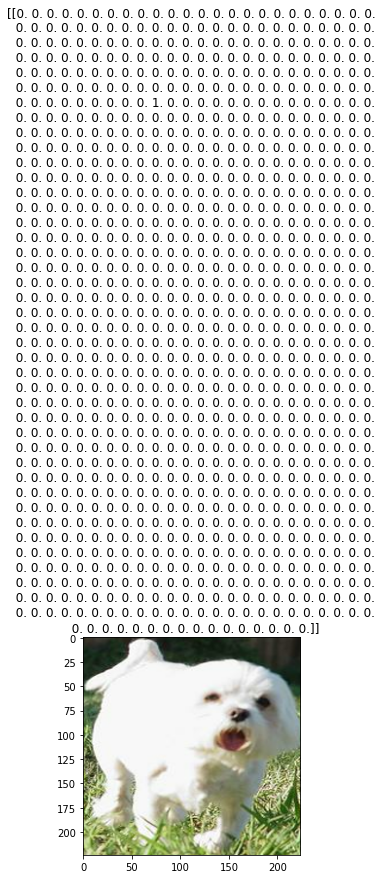

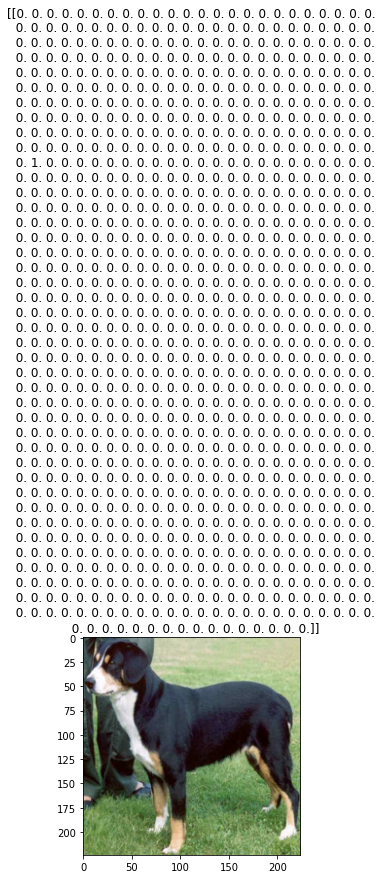

In [ ]:
ds_big, ds_info = tfds.load(
    dataset_name, split="train", with_info=True
)
ds_mini = ds_big.take(400)

def clip_and_resize_np(big, box):
    # print('box', box)
    h = big.shape[0]
    w = big.shape[1]
    ibox = np.zeros((4,), dtype='int32')
    ibox[0] = box[0] * h
    ibox[1] = box[2] * h
    ibox[2] = box[1] * w
    ibox[3] = box[3] * w
    # print('ibox', ibox)
    part = big[ibox[0]:ibox[1], ibox[2]:ibox[3], :]
    # print('part', part.shape)
    img = Image.fromarray(part, mode='RGB')
    resized = img.resize((IMG_SIZE, IMG_SIZE))
    return np.asarray(resized)

def input_preprocess(dict):
    image = dict['image']
    label = dict['label']
    bbox = dict['objects']['bbox']
    # print('image', image.shape)
    # print('label', label.shape)
    # print('bbox', bbox.shape)
    # print(type(image))
    # print(type(label), type(bbox))
    # print(dir(image))
    # print(bbox)
    small = clip_and_resize_np(image.numpy(), bbox.numpy()[0])
    mapped = sd2imagenet(int(label))
    onehot = tf.one_hot(mapped, IMAGENET_CLASSES)
    # print('onehot.shape', onehot.shape)
    return small, np.reshape(onehot.numpy(), (1, 1000))
    return small, mapped # np.asarray([mapped], dtype='int32')

""" Keras-friendly generator that talks a dataset with image&bbox, and clips to the bbox """
def crop_resize_dataset(ds):
    for dog in ds:
        # print(type(dog))
        # print(len(dog))
        yield input_preprocess(dog)

get_name = ds_info.features['label'].int2str

for image, label in ds_train.take(1):
    print(type(label))
    print(label)
    print(label.numpy())

for i, (image,label) in enumerate(crop_resize_dataset(ds_mini)):
    # print('image', image.shape)
    # print('label', label.shape)
    if i % 100 == 0:
        plt.figure()
        plt.imshow(image)
        plt.title(str(label))

# for i, (image,label) in enumerate(crop_resize_dataset(ds_big)):
#     print('i', i)
#     pass


In [ ]:
ds_big, ds_info = tfds.load(
    dataset_name, split="train", with_info=True
)

# have to recode this for tf.image? Or raw tensors?
def clip_and_resize_np(big, box):
    # print('box', box)
    h = big.shape[0]
    w = big.shape[1]
    ibox = np.zeros((4,), dtype='int32')
    ibox[0] = box[0] * h
    ibox[1] = box[2] * h
    ibox[2] = box[1] * w
    ibox[3] = box[3] * w
    # print('ibox', ibox)
    part = big[ibox[0]:ibox[1], ibox[2]:ibox[3], :]
    # print('part', part.shape)
    img = Image.fromarray(part, mode='RGB')
    resized = img.resize((IMG_SIZE, IMG_SIZE))
    return np.asarray(resized)

def input_preprocess_tf(dict):
    image = dict['image']
    label = dict['label']
    bbox = dict['objects']['bbox']
    print('image', image.shape)
    print('label', label.shape)
    print('bbox', bbox.shape)
    print(type(image))
    print(type(label), type(bbox))
    # print(dir(image))
    # print(bbox)
    small = clip_and_resize_np(image.numpy(), bbox.numpy()[0])
    mapped = sd2imagenet(int(label))
    onehot = tf.one_hot(mapped, IMAGENET_CLASSES)
    return small, np.reshape(onehot.numpy(), (1, 1000))
    # return small, np.asarray([mapped], dtype='int32')

ds_big = ds_big.map(lambda data: (input_preprocess_tf(data)))
ds_big = ds_big.batch(batch_size=batch_size, drop_remainder=True)
ds_big = ds_big.prefetch(tf.data.AUTOTUNE)


get_name = ds_info.features['label'].int2str

for i, (image,label) in enumerate(ds_big):
    # print('image', image.shape)
    # print('label', label.shape)
    if i % 1000 == 0:
        plt.figure()
        plt.imshow(image)
        plt.title(str(label))

# for i, (image,label) in enumerate(crop_resize_dataset(ds_big)):
#     print('i', i)
#     pass


image (None, None, 3)
label ()
bbox (None, 4)
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'> <class 'tensorflow.python.framework.ops.Tensor'>


AttributeError: ignored

In [ ]:
# def clone_layer(layer):
#     print('clone_layer:', layer.name)
#     return layer.__class__.from_config(layer.get_config())

def build_masked_effnet(mask):
    assert type(mask) == type([]) and type(mask[0]) == type(1.0)
    effnet = EfficientNetB0(weights='imagenet')
    effnet.trainable = False
    m = tf.keras.models.Sequential()
    m.add(effnet)

    mask_layer = tf.keras.layers.Lambda(lambda x: x * mask)
    m.add(mask_layer)
    softmax_layer = tf.keras.layers.Softmax()
    m.add(softmax_layer)
    m.compile(optimizer='Adam', loss="categorical_crossentropy", metrics=["accuracy"])
    m.trainable = False
    return m

In [ ]:
effnet = EfficientNetB0(weights='imagenet')
effnet.trainable = False
effnet.compile(optimizer='Adam', loss="categorical_crossentropy", metrics=["accuracy"])
# print(effnet.evaluate(ds_train))
# print(effnet.evaluate(ds_test))
print(effnet.evaluate(crop_resize_dataset(ds_big.take(32)), batch_size=32))


32/32 [==============================] - 4s 23ms/step - loss: 0.8192 - accuracy: 0.8125
[0.8192195892333984, 0.8125]


In [ ]:
dogs_model = build_masked_effnet(STANFORD_DOGS_MASK)
print(dogs_model.evaluate(ds_train.take(100)))
print(dogs_model.evaluate(ds_test.take(100)))

100/100 [==============================] - 29s 226ms/step - loss: 6.2603 - accuracy: 0.8566
[6.260258197784424, 0.8565624952316284]
 89/100 [=========================>....] - ETA: 1s - loss: 6.2536 - accuracy: 0.8694

KeyboardInterrupt: ignored

In [ ]:
animals_model = build_masked_effnet(ANIMALS_MASK)
print(animals_model.evaluate(ds_train))
print(animals_model.evaluate(ds_test))

 94/187 [==============>...............] - ETA: 13s - loss: 6.2618 - accuracy: 0.8509

KeyboardInterrupt: ignored

In [ ]:
print(effnet.evaluate(crop_resize_dataset(ds2_mini), batch_size=32))
print(effnet.evaluate(crop_resize_dataset(ds2_test.take(100)), batch_size=32))


ValueError: ignored

In [ ]:
print(animals_model.evaluate(crop_resize_dataset(ds2_train.take(100))))
print(animals_model.evaluate(crop_resize_dataset(ds2_test.take(100))))

In [ ]:
print(dogs_model.evaluate(crop_resize_dataset(ds2_train.take(100))))
print(dogs_model.evaluate(crop_resize_dataset(ds2_test.take(100))))

Now try clipping out the bbox'd part of each image, to make a 224x224 stretched dog image.

In [ ]:
def get_bboxes(ds):
    bboxes = []
    for doggo in dataset['train'].take(10):
        bbox = doggo['objects']['bbox'].numpy()[0]
        bboxes.append(bbox)
    return bboxes

def clip_and_resize_np(big, box):
    h = big.shape[0]
    w = big.shape[1]
    ibox = np.zeros((4,), dtype='int32')
    ibox[0] = box[0] * h
    ibox[1] = box[2] * w
    ibox[2] = box[1] * h
    ibox[3] = box[3] * w
    part = big[ibox[0]:ibox[1], ibox[2]:ibox[3], :]
    img = Image.fromarray(part, mode='RGB')
    resized = img.resize((IMG_SIZE, IMG_SIZE))
    return np.asarray(resized)

def input_preprocess(dict):
    image = dict['image']
    label = dict['label']
    bbox = dict['objects']['bbox']
    print('image', image.shape)
    print('label', label.shape)
    print('bbox', bbox.shape)
    print(type(image))
    print(type(label), type(bbox))
    print(dir(image))
    print(dir(bbox))
    print('image.eval', image.eval(session=sess))
    small = clip_and_resize_np(image.numpy(), bbox.numpy()[0])
    mapped = sd2imagenet(int(label))
    onehot = tf.one_hot(mapped, IMAGENET_CLASSES)
    return tf.convert_to_tensor(small), onehot

SD_CLASSES = ds_info.features["label"].num_classes
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))
# forget input augmentation as we are not training
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)

In [ ]:
import functools
def decode_example(image, dict):
    print(type(image))
    print(dict)
    crop_y, crop_x, crop_height, crop_width = 10, 10, 64, 64
    return tf.image.decode_and_crop_jpeg(
        image,
        [crop_y, crop_x, crop_height, crop_width],
        channels=image.shape[-1],
  )

ds, ds_info = tfds.load(
    dataset_name,
    split='train',
    with_info=True,
    decoders={
        'image': tfds.decode.SkipDecoding(),  # Skip frame decoding
    },
)
ds = ds.map(functools.partial(decode_example, dict=ds_info.features))

In [ ]:
@tfds.decode.make_decoder()
def decode_example(serialized_image, feature):
  print(type(serialized_image))
  print(type(feature))
  print(dir(feature))
  crop_y, crop_x, crop_height, crop_width = 10, 10, 64, 64
  return tf.image.decode_and_crop_jpeg(
      serialized_image,
      [crop_y, crop_x, crop_height, crop_width],
      channels=feature.shape[-1],
  )

ds = tfds.load(dataset_name, split='train', decoders={
    # With video, decoders are applied to individual frames
    'image': decode_example(),
})

get_name = info.features['label'].int2str

for doggo in dataset['train'].take(10):
    plt.figure()
    plt.imshow(doggo['image'])
    plt.title(get_name(doggo['label']))

In [ ]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


# plot_hist(hist)

In [ ]:
dataset, info = tfds.load(name="stanford_dogs", with_info=True)

get_name = info.features['label'].int2str

for doggo in dataset['train'].take(10):
    plt.figure()
    plt.imshow(doggo['image'])
    plt.title(get_name(doggo['label']))

In [ ]:
from PIL import Image
dataset, info = tfds.load(name="stanford_dogs", with_info=True)

get_name = info.features['label'].int2str

def clip(big, box):
    print('big', big.shape)
    h = big.shape[0]
    w = big.shape[1]
    print('box', box.shape, box)
    ibox = np.zeros((4,), dtype='int32')
    tup = [0,2,1,3]
    ibox[0] = box[tup[0]] * h
    ibox[1] = box[tup[1]] * w
    ibox[2] = box[tup[2]] * h
    ibox[3] = box[tup[3]] * w
    print('ibox', ibox)
    small = big[ibox[0]:ibox[1], ibox[2]:ibox[3], :]
    return small
    
def resize(part):
    part = part # * 255
    img = Image.fromarray(part, mode='RGB')
    print('img', img)
    resized = img.resize((IMG_SIZE, IMG_SIZE))
    print('resized', resized)
    out = np.asarray(resized)
    return out 

for doggo in dataset['train'].take(10):
    plt.figure()
    big = doggo['image'].numpy()
    box = doggo['objects']['bbox'].numpy()[0]
    clipped = clip(big, box)
    small = resize(clipped)
    print('small', small.shape)
    plt.imshow(small)
    plt.title(get_name(doggo['label']))

In [ ]:
from PIL import Image
dataset, info = tfds.load(name="stanford_dogs", with_info=True)

get_name = info.features['label'].int2str

def clip_and_resize(big, box):
    h = big.shape[0]
    w = big.shape[1]
    ibox = np.zeros((4,), dtype='int32')
    tup = [0,2,1,3]
    ibox[0] = box[0] * h
    ibox[1] = box[2] * w
    ibox[2] = box[1] * h
    ibox[3] = box[3] * w
    part = big[ibox[0]:ibox[1], ibox[2]:ibox[3], :]
    img = Image.fromarray(part, mode='RGB')
    resized = img.resize((IMG_SIZE, IMG_SIZE))
    return np.asarray(resized)

for doggo in dataset['train'].take(10):
    plt.figure()
    big = doggo['image'].numpy()
    box = doggo['objects']['bbox'].numpy()[0]
    print(type(doggo['image']))
    small = clip_and_resize(big, box)
    plt.imshow(small)
    plt.title(get_name(doggo['label']))